In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
%matplotlib notebook

In [3]:
import pandas as pd

a = pd.read_csv('drive_data.csv')

In [4]:
a.keys()

Index(['Fuel_consumption', 'Accelerator_Pedal_value',
       'Throttle_position_signal', 'Short_Term_Fuel_Trim_Bank1',
       'Intake_air_pressure', 'Filtered_Accelerator_Pedal_value',
       'Absolute_throttle_position', 'Engine_soacking_time',
       'Inhibition_of_engine_fuel_cut_off', 'Engine_in_fuel_cut_off',
       'Fuel_Pressure', 'Long_Term_Fuel_Trim_Bank1', 'Engine_speed',
       'Engine_torque_after_correction', 'Torque_of_friction',
       'Flywheel_torque_(after_torque_interventions)', 'Current_spark_timing',
       'Engine_coolant_temperature', 'Engine_Idel_Target_Speed',
       'Engine_torque', 'Calculated_LOAD_value',
       'Minimum_indicated_engine_torque', 'Maximum_indicated_engine_torque',
       'Flywheel_torque', 'Torque_scaling_factor(standardization)',
       'Standard_Torque_Ratio', 'Requested_spark_retard_angle_from_TCU',
       'TCU_requests_engine_torque_limit_(ETL)',
       'TCU_requested_engine_RPM_increase',
       'Target_engine_speed_used_in_lock-up_modu

In [5]:
#driverA = a[a['Class']=='A']['Vehicle_speed']
driverA = a[a['Class']=='A']['Acceleration_speed_-_Longitudinal']


In [6]:
driverData = driverA.values
driverData = np.expand_dims(driverData, axis=1)

In [7]:
driverData.shape

(7239, 1)

# Generate Synthetic Data

# Define hyperparameters

In [8]:
# of samples per sensor for the micro model [sliding window of ~2.5 hrs]
hParams = {}
hParams['windowSamples'] = 50
hParams['nSensors'] = 1
hParams['overlapPercentage'] = .99
hParams['advanceSamples'] = ( hParams['windowSamples'] - int( np.floor( hParams['windowSamples'] * hParams['overlapPercentage'] ) ))

# Split into train and test set (.25 test data)

In [9]:
def train_test_split (x, testDataRatio = .25, trainDataAtStart = True):
    assert x.ndim > 1
    if trainDataAtStart:
        splitIndex = int( ( 1.0 - testDataRatio) * x.shape[0] )    
        
        xTrain = x[ 0:splitIndex, :]
        xTest = x[ splitIndex:, :]
    else:
        splitIndex = int( testDataRatio * x.shape[0] )
        xTest = x[ 0:splitIndex, :]
        xTrain = x[ splitIndex:, :]
        
    return xTrain, xTest

In [10]:
#trainSplit, testSplit = train_test_split( syntheticData )
trainSplit, testSplit = train_test_split( driverData )

In [11]:
trainSplit.shape

(5429, 1)

In [12]:
testSplit.shape

(1810, 1)

# No augmentation / noise injection

# Normalize data ( 0 mean, unit standard deviation )

In [13]:
# find normalization statistics
trainMeans = np.mean(trainSplit, axis=0)
trainSTDevs = np.std(trainSplit, axis=0)
print(trainMeans); print(trainSTDevs)

# normalize [ in place / overwrite ]
normalizedTrainData = (trainSplit - trainMeans) / (trainSTDevs + .0001)
normalizedTestData = (testSplit - trainMeans) / (trainSTDevs + .0001)

[-0.07132069]
[ 0.75609205]


# Generate shuffled windows

In [14]:
def reshape_into_shuffled_data_windows ( x, windowSize, advanceSamples ):
    nWindows = int( np.floor( (x.shape[0] - windowSize)/(advanceSamples*1.0) ) )
    # shuffle indexes
    shuffledWindowInds = np.arange(nWindows)
    np.random.shuffle(shuffledWindowInds)    
        
    nSensors = x.shape[1]
    outputMatrix = np.zeros((nWindows, windowSize * nSensors))
    
    # update data matrix on a row by row basis (choosing shuffled windows per row)
    for iWindow in range(nWindows):
        startIndex = shuffledWindowInds[iWindow] * advanceSamples
        endIndex = startIndex + windowSize
        
        # flatten/interleave sensor values
        for iSensor in range(nSensors):
            outputMatrix[iWindow, iSensor::nSensors] = x[startIndex:endIndex, iSensor]
    
    return outputMatrix, shuffledWindowInds


<IPython.core.display.Javascript object>


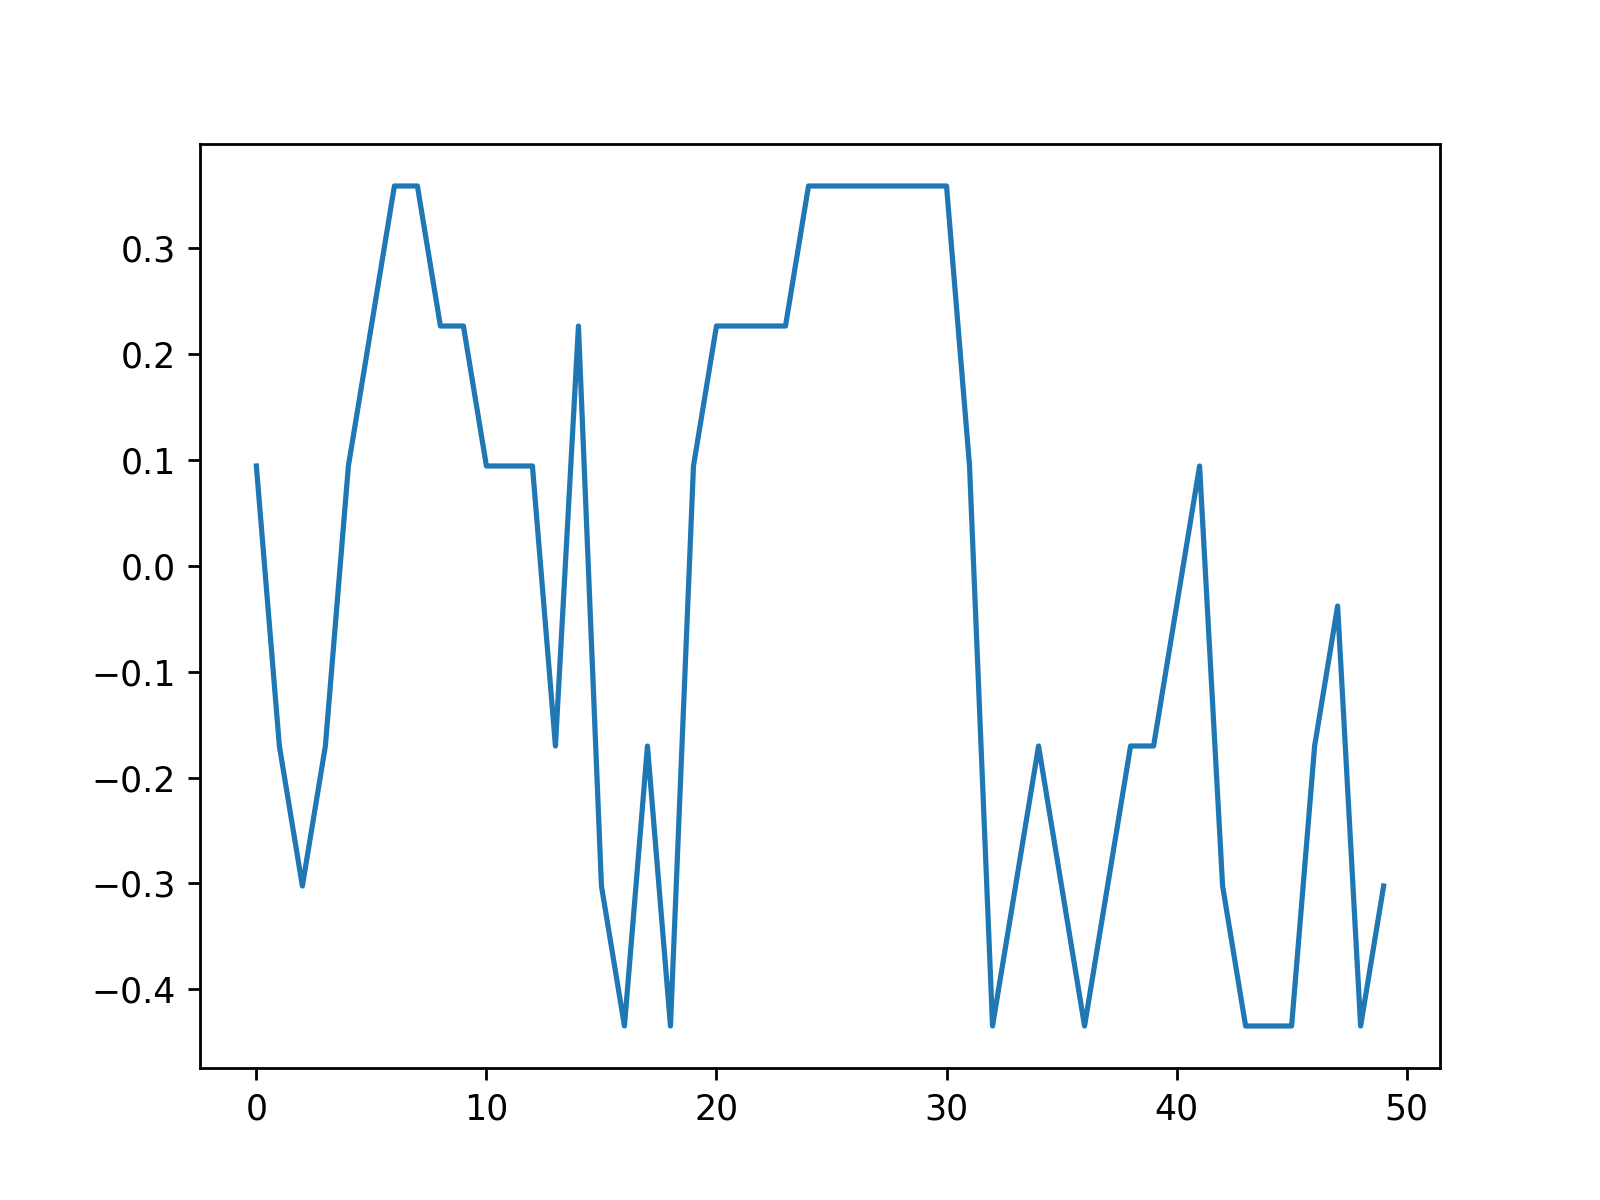

In [15]:
trainMatrix, trainShuffledWindowInds = reshape_into_shuffled_data_windows(normalizedTrainData, hParams['windowSamples'], hParams['advanceSamples'])
testMatrix, testShuffledWindowInds = reshape_into_shuffled_data_windows(normalizedTestData, hParams['windowSamples'], hParams['advanceSamples'])

viz_flag = 1
if viz_flag:
    plt.figure()
    plt.plot(trainMatrix[200,:])


In [16]:
trainMatrix.shape

(5379, 50)

In [17]:
testMatrix.shape

(1760, 50)

# ML/DL Imports

In [18]:
from keras.models import Sequential, Model
from keras.layers import Dense
from keras import metrics
from keras import initializers
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint

Using TensorFlow backend.


# Model definition

In [19]:
hParams['inputOutputDimensionality'] = int( hParams['windowSamples'] * hParams['nSensors'] ) 
assert hParams['inputOutputDimensionality'] == trainMatrix.shape[1]

# Define model
model = Sequential()
model.add( Dense( 30, input_dim = hParams['inputOutputDimensionality'], activation = 'linear'))
model.add( Dense( 15, activation = 'sigmoid'))
model.add( Dense( 30, activation = 'sigmoid'))
model.add( Dense( hParams['inputOutputDimensionality'], activation = 'linear',))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 30)                1530      
_________________________________________________________________
dense_2 (Dense)              (None, 15)                465       
_________________________________________________________________
dense_3 (Dense)              (None, 30)                480       
_________________________________________________________________
dense_4 (Dense)              (None, 50)                1550      
Total params: 4,025
Trainable params: 4,025
Non-trainable params: 0
_________________________________________________________________


<IPython.core.display.Javascript object>


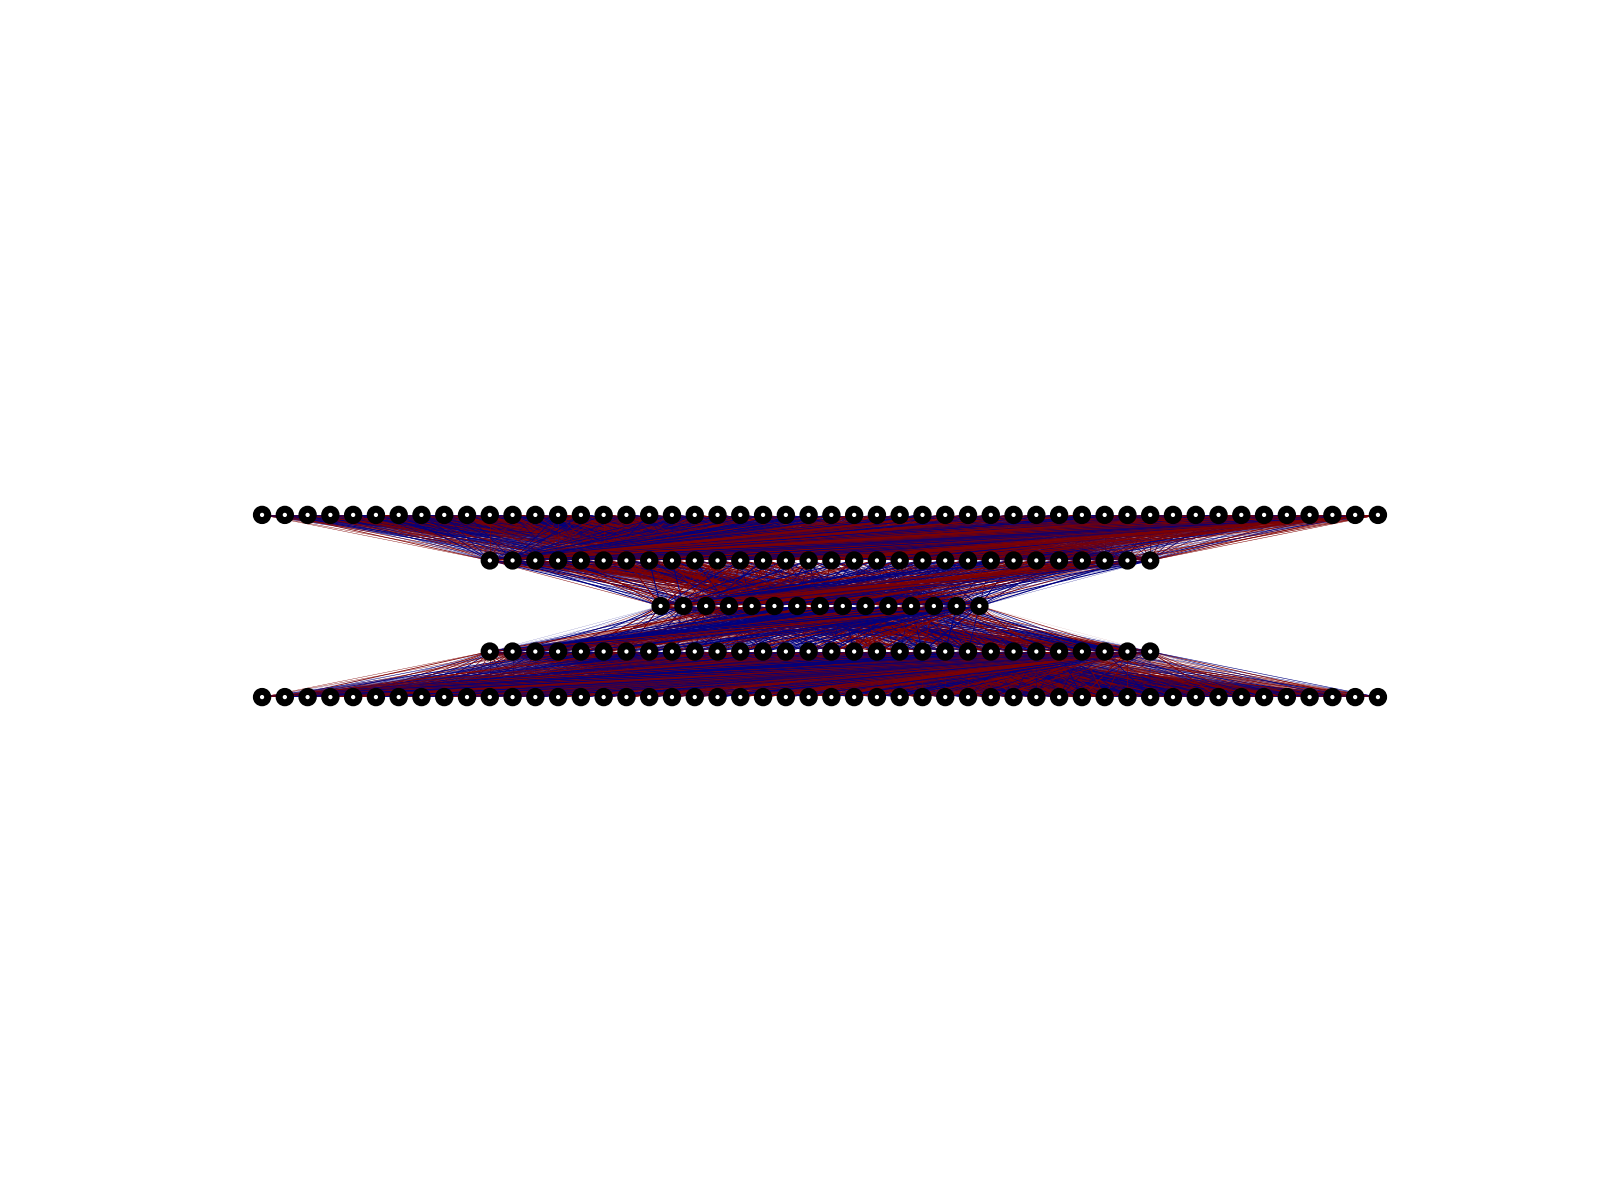

In [20]:
import nnViz
plt.figure()
nnViz.visualize_model(model)

In [21]:
model.compile(optimizer = 'adam', loss = 'mse')

In [27]:
early_stopping = EarlyStopping( monitor = 'val_loss', patience = 10)
checkpointer = ModelCheckpoint( filepath = 'synthetic_sin_weights.hdf5', verbose=1, save_best_only = True)

model.fit( trainMatrix,
           trainMatrix,
           batch_size = 256, epochs = 1000,
           shuffle = True,
           callbacks = [early_stopping, checkpointer],
           validation_data = (testMatrix, testMatrix) )

Train on 5379 samples, validate on 1760 samples
Epoch 1/1000
5379/5379 [==============================] - 0s - loss: 0.1769 - val_loss: 0.1097
Epoch 2/1000
5379/5379 [==============================] - 0s - loss: 0.1768 - val_loss: 0.1097
Epoch 3/1000
5379/5379 [==============================] - 0s - loss: 0.1777 - val_loss: 0.1102
Epoch 4/1000
5379/5379 [==============================] - 0s - loss: 0.1778 - val_loss: 0.1095
Epoch 5/1000
5379/5379 [==============================] - 0s - loss: 0.1764 - val_loss: 0.1092
Epoch 6/1000
5379/5379 [==============================] - 0s - loss: 0.1762 - val_loss: 0.1089
Epoch 7/1000
5379/5379 [==============================] - 0s - loss: 0.1761 - val_loss: 0.1092
Epoch 8/1000
5379/5379 [==============================] - 0s - loss: 0.1761 - val_loss: 0.1093
Epoch 9/1000
5379/5379 [==============================] - 0s - loss: 0.1759 - val_loss: 0.1090
Epoch 10/1000
5379/5379 [==============================] - 0s - loss: 0.1761 - val_loss: 0.1108
E

5379/5379 [==============================] - 0s - loss: 0.1738 - val_loss: 0.1066
Epoch 37/1000
5379/5379 [==============================] - 0s - loss: 0.1733 - val_loss: 0.1065
Epoch 38/1000
5379/5379 [==============================] - 0s - loss: 0.1734 - val_loss: 0.1062
Epoch 39/1000
5379/5379 [==============================] - 0s - loss: 0.1726 - val_loss: 0.1062
Epoch 40/1000
5379/5379 [==============================] - 0s - loss: 0.1726 - val_loss: 0.1058
Epoch 41/1000
5379/5379 [==============================] - 0s - loss: 0.1721 - val_loss: 0.1059
Epoch 42/1000
5379/5379 [==============================] - 0s - loss: 0.1728 - val_loss: 0.1058
Epoch 43/1000
5379/5379 [==============================] - 0s - loss: 0.1724 - val_loss: 0.1055
Epoch 44/1000
5379/5379 [==============================] - 0s - loss: 0.1717 - val_loss: 0.1054
Epoch 45/1000
5379/5379 [==============================] - 0s - loss: 0.1715 - val_loss: 0.1057
Epoch 46/1000
5379/5379 [=============================

5379/5379 [==============================] - 0s - loss: 0.1633 - val_loss: 0.0992
Epoch 106/1000
5379/5379 [==============================] - 0s - loss: 0.1635 - val_loss: 0.0994
Epoch 107/1000
5379/5379 [==============================] - 0s - loss: 0.1644 - val_loss: 0.0993
Epoch 108/1000
5379/5379 [==============================] - 0s - loss: 0.1630 - val_loss: 0.0995
Epoch 109/1000
5379/5379 [==============================] - 0s - loss: 0.1640 - val_loss: 0.0992
Epoch 110/1000
5379/5379 [==============================] - 0s - loss: 0.1630 - val_loss: 0.0992
Epoch 111/1000
5379/5379 [==============================] - 0s - loss: 0.1643 - val_loss: 0.0997
Epoch 112/1000
5379/5379 [==============================] - 0s - loss: 0.1662 - val_loss: 0.1000
Epoch 113/1000
5379/5379 [==============================] - 0s - loss: 0.1658 - val_loss: 0.0994
Epoch 114/1000
5379/5379 [==============================] - 0s - loss: 0.1636 - val_loss: 0.0991
Epoch 115/1000
5379/5379 [===================

5379/5379 [==============================] - 0s - loss: 0.1604 - val_loss: 0.0975
Epoch 144/1000
5379/5379 [==============================] - 0s - loss: 0.1603 - val_loss: 0.0978
Epoch 145/1000
5379/5379 [==============================] - 0s - loss: 0.1611 - val_loss: 0.0976
Epoch 146/1000
5379/5379 [==============================] - 0s - loss: 0.1603 - val_loss: 0.0976
Epoch 147/1000
5379/5379 [==============================] - 0s - loss: 0.1609 - val_loss: 0.0978
Epoch 148/1000
5379/5379 [==============================] - 0s - loss: 0.1605 - val_loss: 0.0975
Epoch 149/1000
5379/5379 [==============================] - 0s - loss: 0.1601 - val_loss: 0.0974
Epoch 150/1000
5379/5379 [==============================] - 0s - loss: 0.1601 - val_loss: 0.0973
Epoch 151/1000
5379/5379 [==============================] - 0s - loss: 0.1598 - val_loss: 0.0973
Epoch 152/1000
5379/5379 [==============================] - 0s - loss: 0.1599 - val_loss: 0.0972
Epoch 153/1000
5379/5379 [===================

# Load best model weights

In [28]:
model.load_weights("synthetic_sin_weights.hdf5")
model.compile(optimizer = 'adam', loss = 'mse') # need to recompile model to be able to run prediction

# Plot raw vs predicted 

In [29]:
def windowed_predict(data, windowSize):    
    nWindows = int( data.size / (windowSize*1.0) )
    print('number of windows: ' + str(nWindows))
    predicted = np.zeros((data.shape[0], data.shape[1]))
    
    for iWindow in range(nWindows):
        dataStartIndex = int( iWindow * windowSize )
        dataEndIndex = dataStartIndex + windowSize
        
        predictedWindow = model.predict( np.transpose( data[dataStartIndex:dataEndIndex]) )
        predicted[dataStartIndex:dataEndIndex] = np.transpose(predictedWindow)
        
    return predicted

In [30]:
predictedData = windowed_predict ( normalizedTestData, hParams['inputOutputDimensionality'])
error = np.sqrt((normalizedTestData - predictedData)**2)

number of windows: 36


<IPython.core.display.Javascript object>


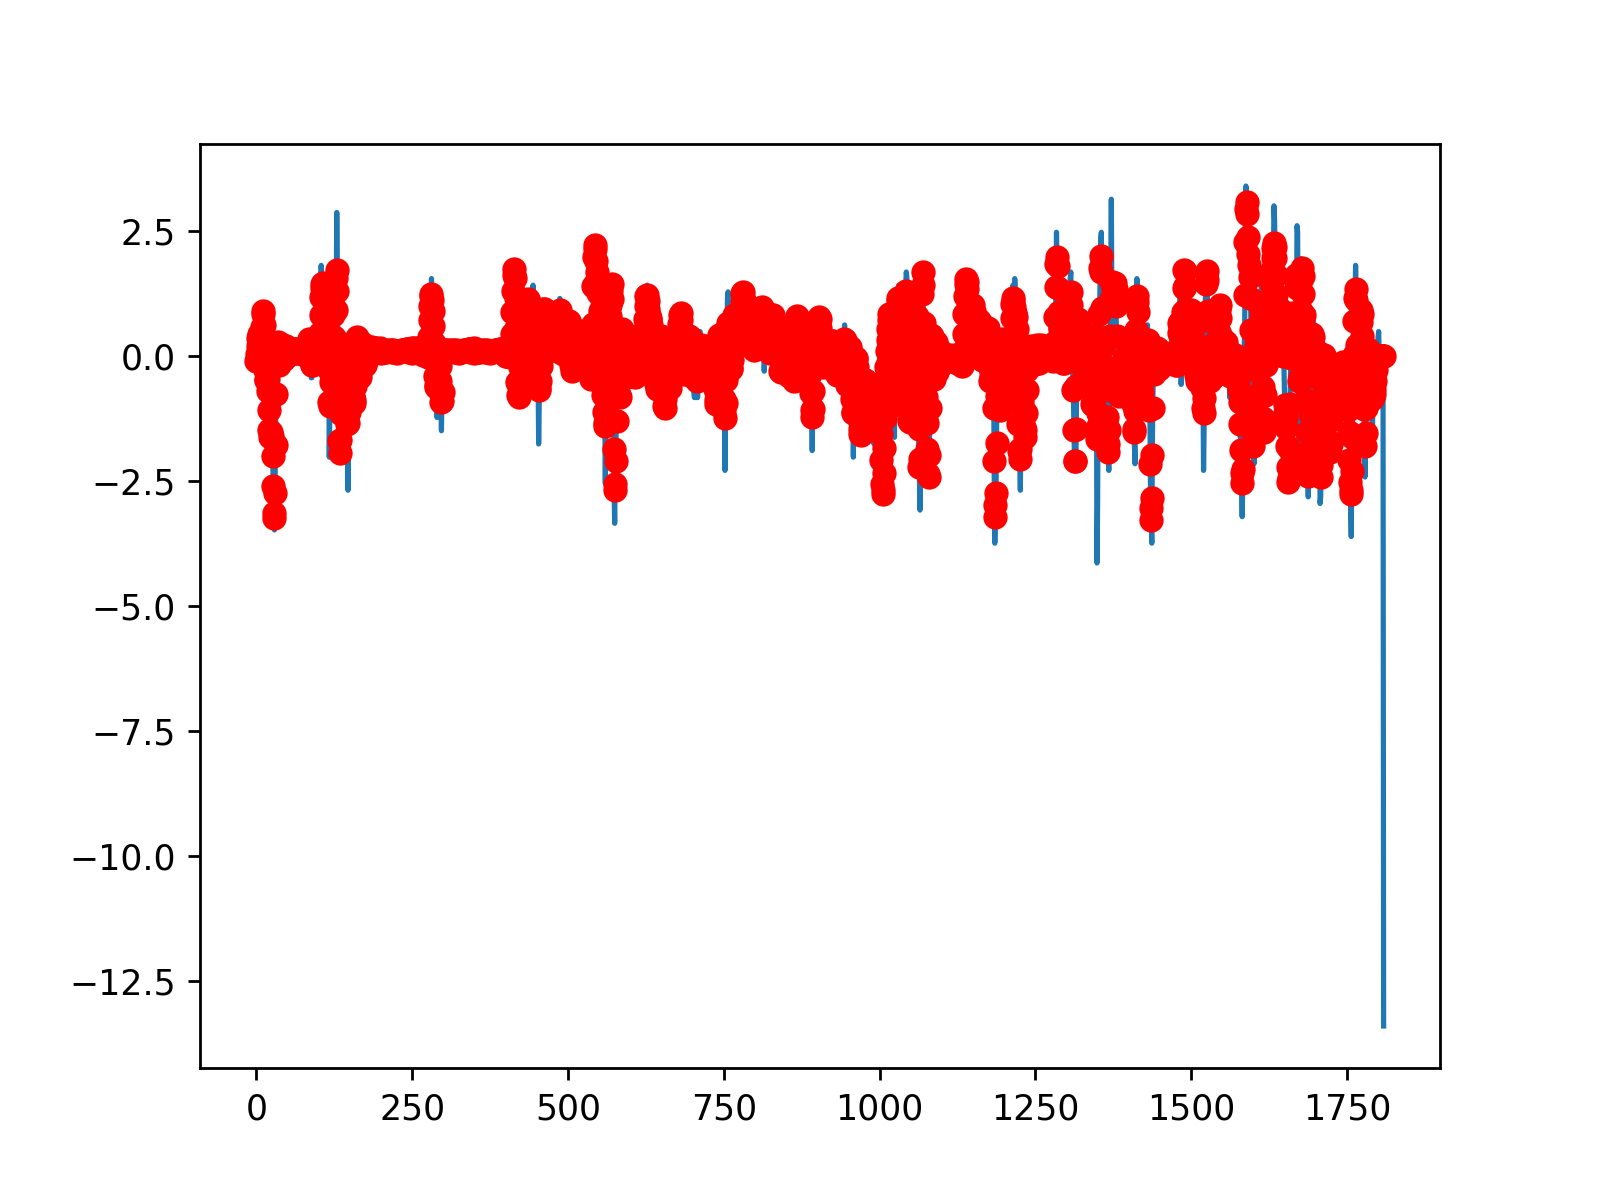

In [31]:
plt.figure()
plt.plot(normalizedTestData)
plt.plot(predictedData, 'ro')


# Inject Anomalies & Predict
TODO -- normalize using training statistics
TODO -- aggressive vs safe driver [ clustering ]
TODO -- anomaly detection dataset 
TODO -- better synthetic anomalies ?

<IPython.core.display.Javascript object>


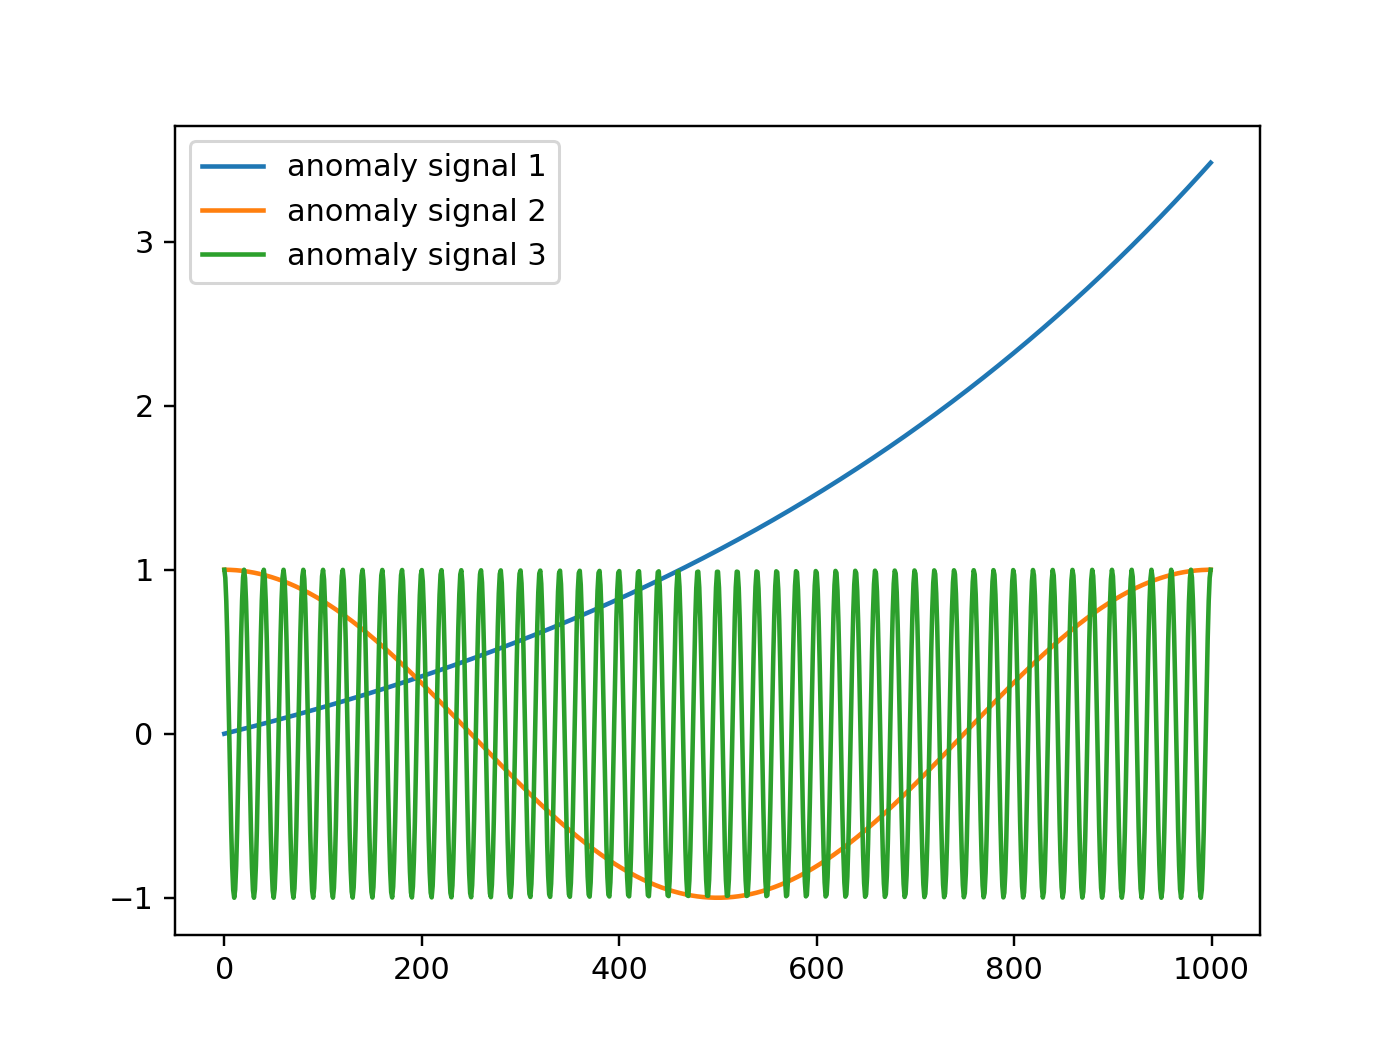

In [52]:
anomalySignal1 = np.exp(np.linspace(0, 1.5, 1000)) - 1
anomalySignal2 = np.cos(np.linspace(0,2*np.pi * 1, 1000))
anomalySignal3 = np.cos(np.linspace(0,2*np.pi * 50, 1000))

anomalySignal1 = np.expand_dims(anomalySignal1, axis=1)
anomalySignal2 = np.expand_dims(anomalySignal2, axis=1)
anomalySignal3 = np.expand_dims(anomalySignal3, axis=1)

plt.figure()
plt.plot(anomalySignal1)
plt.plot(anomalySignal2)
plt.plot(anomalySignal3)
plt.legend(['anomaly signal 1', 'anomaly signal 2', 'anomaly signal 3'])

In [33]:
startIndex = 0
endIndex = 1000
len(anomalySignal1)

1000

In [34]:
targetData = np.concatenate( ( normalizedTestData[0:500], anomalySignal1, \
                               normalizedTestData[500:1000], anomalySignal2, \
                               normalizedTestData[1000:1500], anomalySignal3 ) )

anomalousInds_1 = np.arange(500/hParams['windowSamples'], 1500/hParams['windowSamples'], dtype=int)
anomalousInds_2 = np.arange(2000/hParams['windowSamples'], 3000/hParams['windowSamples'], dtype=int)
anomalousInds_3 = np.arange(3500/hParams['windowSamples'], 4500/hParams['windowSamples'], dtype=int)

In [35]:
predictedData = windowed_predict ( targetData, hParams['inputOutputDimensionality'])
error = np.sqrt((targetData - predictedData)**2)

number of windows: 90


<IPython.core.display.Javascript object>


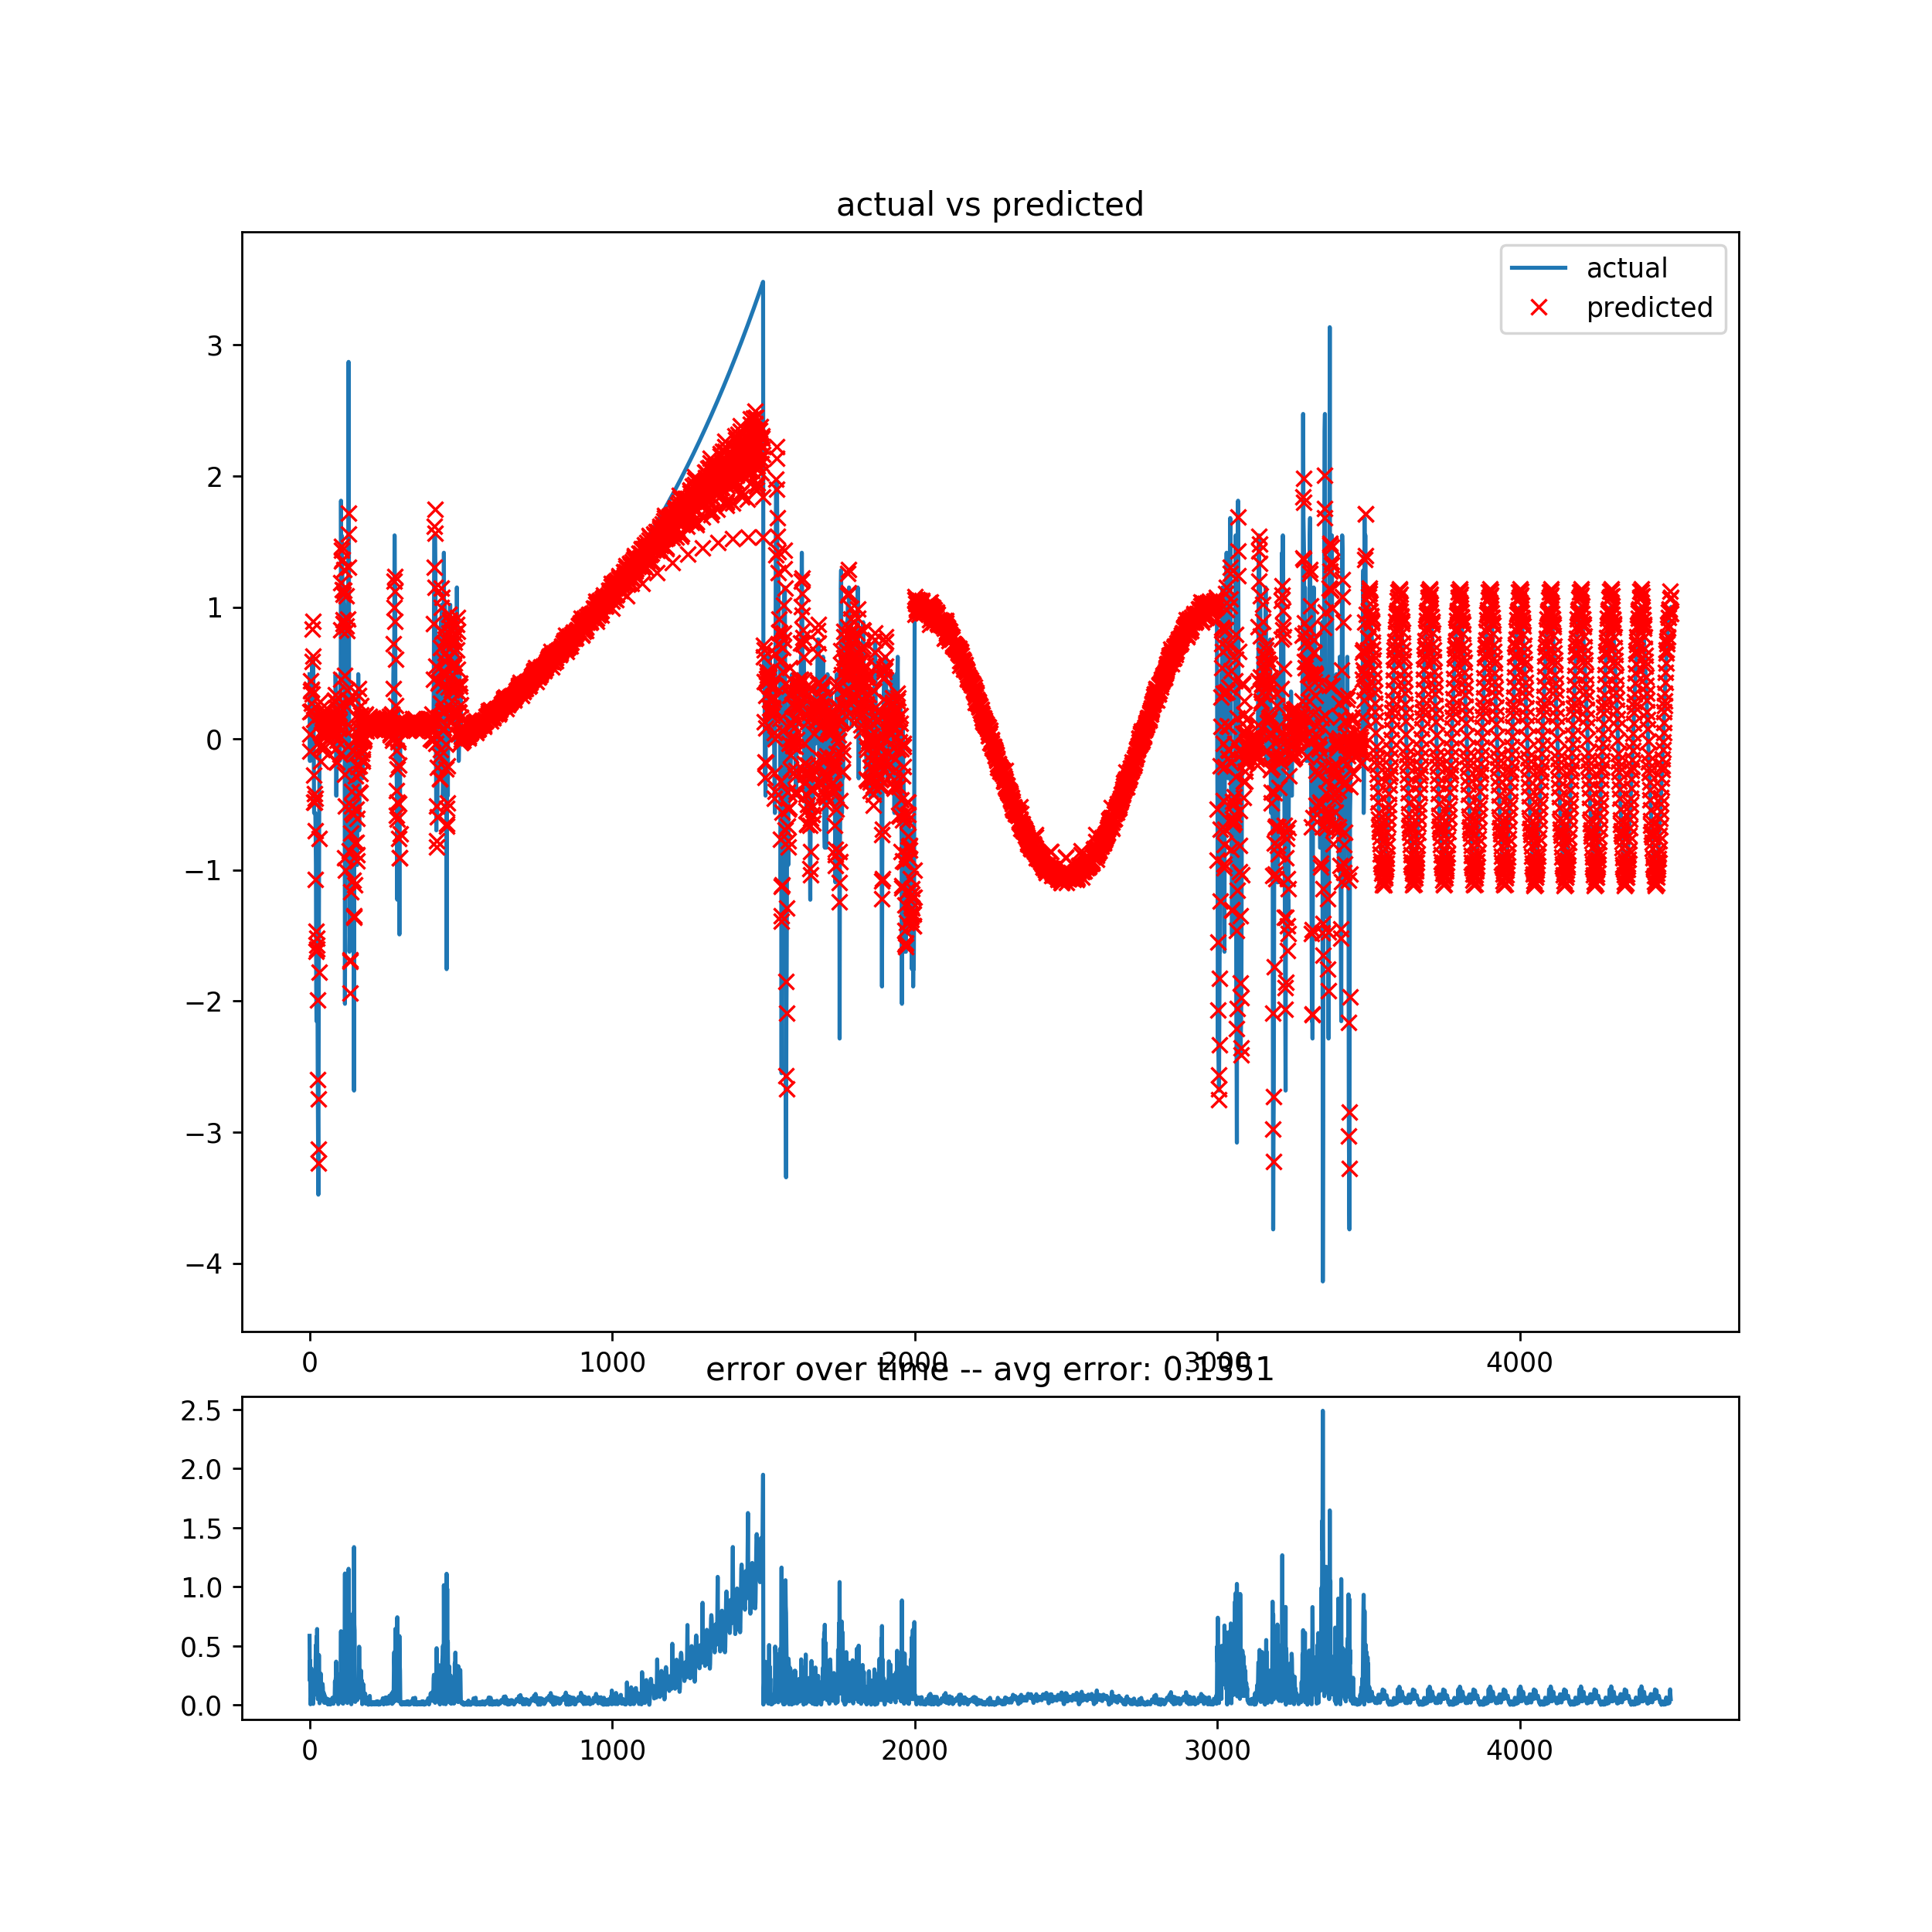

In [36]:
plt.figure(figsize=(10,10))

ax1 = plt.subplot2grid((4, 1), (0, 0), rowspan=3)
ax2 = plt.subplot2grid((4, 1), (3, 0), rowspan=1)

ax1.plot(targetData)
ax1.plot(predictedData, 'rx')
ax1.set_title('actual vs predicted')
ax1.legend(['actual', 'predicted'])

ax2.plot(error)
#ax2.set_ylim([0,5])
ax2.set_title('error over time -- avg error: ' + str(round(np.mean(error),4)))

## Remove last two layers [ focus on bottleneck activations ]

In [37]:
print(len(model.layers))

4


In [38]:
model.pop()
model.pop()

In [39]:
print(len(model.layers))

2


In [40]:
model.compile(optimizer = 'adam', loss = 'mse')

In [41]:
def windowed_predict_bottleneck_activation (data, windowSize, bottleneckSize):    
    nWindows = int( data.size / (windowSize*1.0) )
    print('number of windows: ' + str(nWindows))
    predicted = np.zeros((nWindows, bottleneckSize))
    
    for iWindow in range(nWindows):
        dataStartIndex = int( iWindow * windowSize )
        dataEndIndex = dataStartIndex + windowSize
        
        predictedWindow = model.predict( np.transpose( data[dataStartIndex:dataEndIndex]) )
        predicted[iWindow, :] = predictedWindow[0]
        
        
    return predicted

In [45]:
bottleNeckSize = model.layers[-1].get_config()['units']
bottleneckActivations = windowed_predict_bottleneck_activation (targetData, hParams['inputOutputDimensionality'], bottleNeckSize)

number of windows: 90


In [46]:
from sklearn.manifold import TSNE

embeddedBottleneckActivations = TSNE(n_components = 2, perplexity = 10, learning_rate = 100, method='exact', verbose = 1).fit_transform(bottleneckActivations)

[t-SNE] Computing pairwise distances...
[t-SNE] Computed conditional probabilities for sample 90 / 90
[t-SNE] Mean sigma: 0.093797
[t-SNE] KL divergence after 100 iterations with early exaggeration: 10.281209
[t-SNE] Error after 800 iterations: 10.281209


<IPython.core.display.Javascript object>


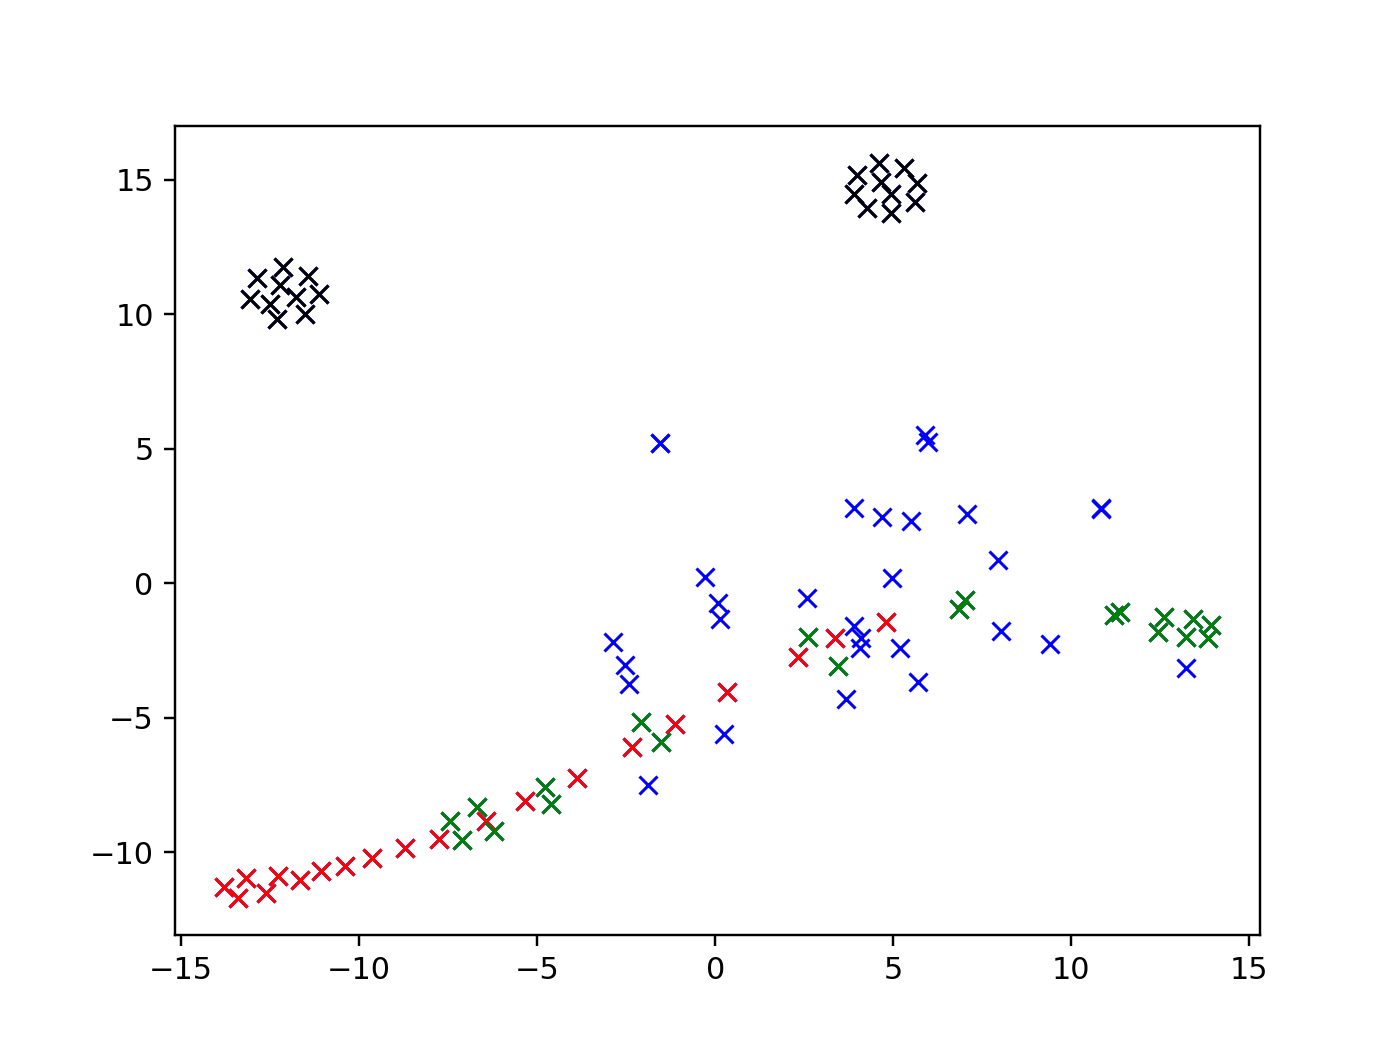

In [48]:
plt.figure()
plt.plot(embeddedBottleneckActivations[:,0], embeddedBottleneckActivations[:,1], 'bx')
plt.plot(embeddedBottleneckActivations[anomalousInds_1,0], embeddedBottleneckActivations[anomalousInds_1,1], 'rx')
plt.plot(embeddedBottleneckActivations[anomalousInds_2,0], embeddedBottleneckActivations[anomalousInds_2,1], 'gx')
plt.plot(embeddedBottleneckActivations[anomalousInds_3,0], embeddedBottleneckActivations[anomalousInds_3,1], 'kx')


In [49]:
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
pca = PCA(n_components=2)
PCA_bottleneckActivations = pca.fit_transform(bottleneckActivations)

<IPython.core.display.Javascript object>


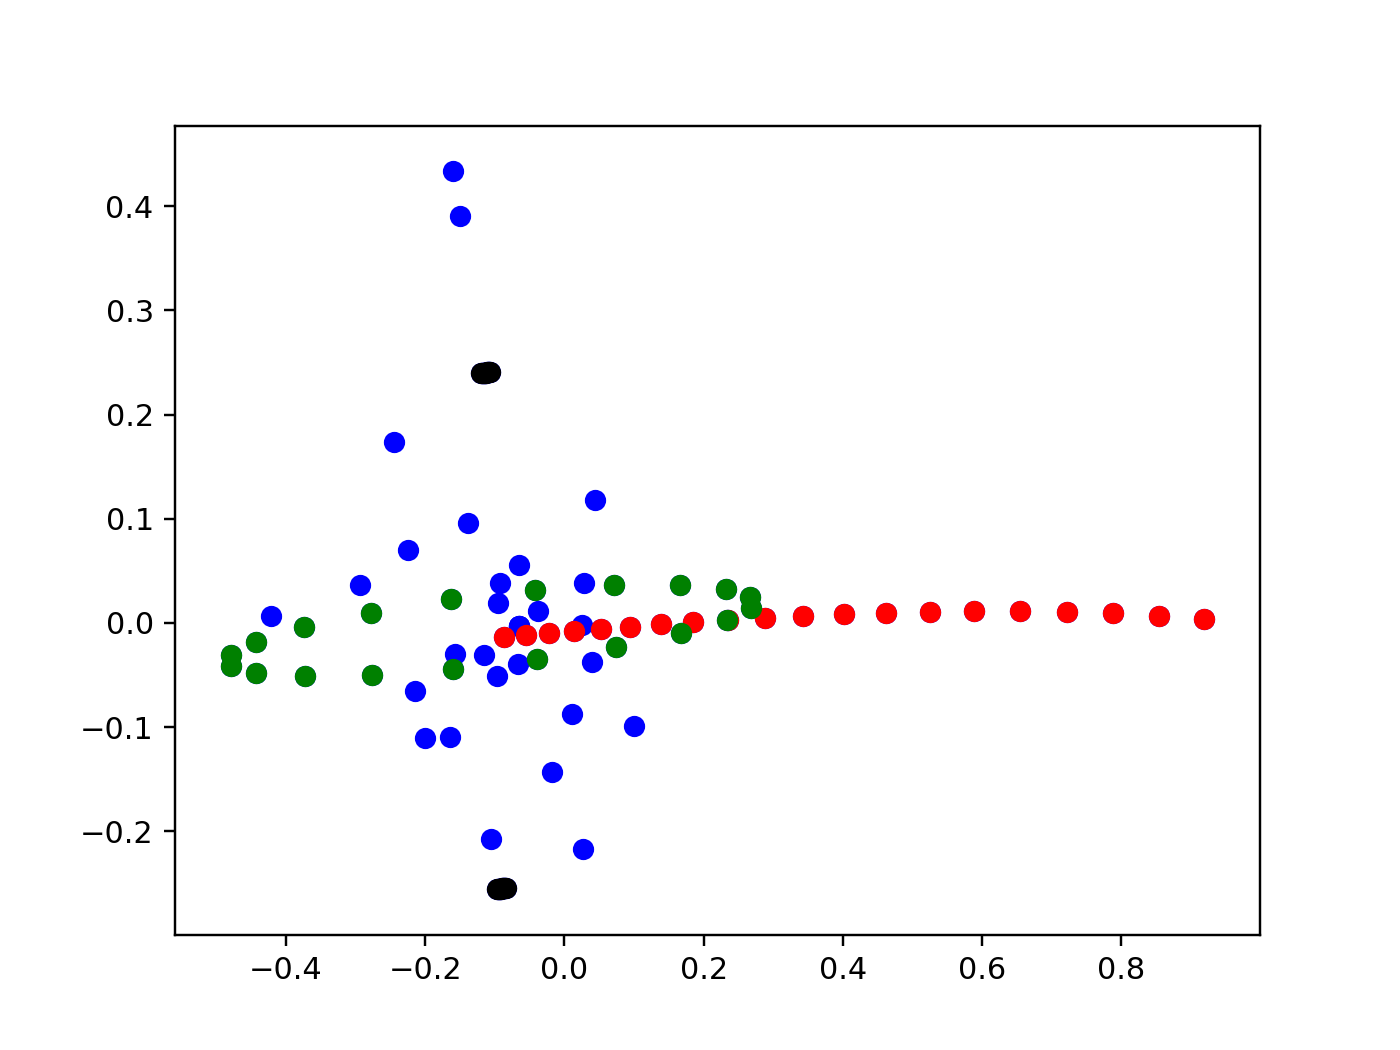

In [50]:
plt.figure()
plt.scatter(PCA_bottleneckActivations[:,0],PCA_bottleneckActivations[:,1], color='b')
plt.scatter(PCA_bottleneckActivations[anomalousInds_1,0],PCA_bottleneckActivations[anomalousInds_1,1], color='r')
plt.scatter(PCA_bottleneckActivations[anomalousInds_2,0],PCA_bottleneckActivations[anomalousInds_2,1], color='g')
plt.scatter(PCA_bottleneckActivations[anomalousInds_3,0],PCA_bottleneckActivations[anomalousInds_3,1], color='k')